# Autometic Judgment Analysis

In [9]:
import pandas as pd
import json
import gzip
from tqdm import tqdm

In [10]:
nist_qrel_file = 'qrels/2023.qrels.pass.withDupes.txt'
gpt4_qrel_file = 'qrels/2023.qrels.pass.gpt4.txt'
dl_2023_queries = 'queries/dl-2023-queries.tsv'

## Loading Judgments

In [11]:
# loading judged queries
nist_qrels = pd.read_csv(nist_qrel_file, sep=' ', header=None, names=['qid', 'Q0', 'docid', 'rel'])
# loading judged queries - GPT-4
gpt4_qrels = pd.read_csv(gpt4_qrel_file, sep=' ', header=None, names=['qid', 'Q0', 'docid', 'rel'])

## Bland Altman Plot

In [14]:
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("ticks")  # Options: white, dark, whitegrid, darkgrid, ticks
sns.set_context("poster")     # Options: paper, notebook, talk, poster
sns.set_palette("bright")   # You can also use: deep, muted, bright, dark, colorblind, or a custom list of colors

In [15]:
human_scores = nist_qrels['rel']
llm_scores = gpt4_qrels['rel']

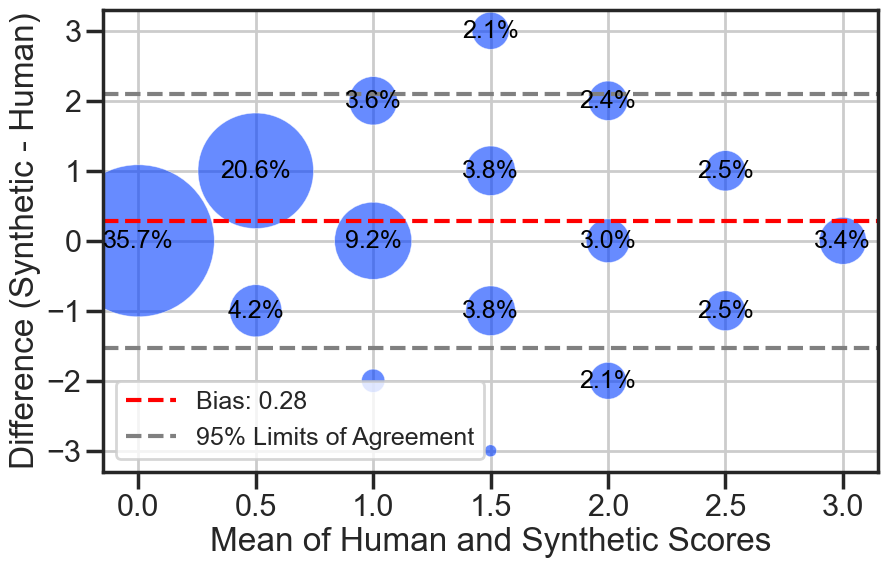

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Calculate mean scores and differences
mean_scores = (human_scores + llm_scores) / 2
differences = llm_scores - human_scores

# Combine mean scores and differences into tuples for counting
points = list(zip(mean_scores, differences))

# Count the frequency of each unique point
point_counts = Counter(points)

# Extract unique points and their counts
unique_points = np.array(list(point_counts.keys()))
frequencies = np.array(list(point_counts.values()))

# Calculate percentages
total_points = len(points)
percentages = (frequencies / total_points) * 100

# Create Bland-Altman plot with point sizes indicating density
plt.figure(figsize=(10, 6))

# Scatter plot with point size based on frequency
plt.scatter(unique_points[:, 0], unique_points[:, 1], s=frequencies * 1.5, alpha=0.6, edgecolors='w', linewidth=0.5)

# Optionally add text annotations for percentage
for (x, y), percentage in zip(unique_points, percentages):
    if percentage > 1:  # Only annotate if the percentage is greater than 1%
        plt.text(x, y, f'{percentage:.1f}%', fontsize=18, ha='center', va='center', color='black')

# Add lines for mean difference and limits of agreement
mean_diff = np.mean(differences)
std_diff = np.std(differences)

plt.axhline(mean_diff, color='red', linestyle='--', label=f'Bias: {mean_diff:.2f}')
plt.axhline(mean_diff + 1.96*std_diff, color='gray', linestyle='--', label='95% Limits of Agreement')
plt.axhline(mean_diff - 1.96*std_diff, color='gray', linestyle='--')

plt.xlabel('Mean of Human and Synthetic Scores')
plt.ylabel('Difference (Synthetic - Human)')
# plt.title('Bland-Altman Plot with Point Density Indication')
plt.legend(fontsize=18)
plt.grid(True)
plt.savefig("figs/bland_altman_plot_scores_with_precentage.pdf", bbox_inches="tight")
# plt.show()